In [1]:
# Imports
import logging
logging.basicConfig(
    level=logging.INFO
)

import warnings
warnings.filterwarnings('ignore')

from typing import Union, Iterable, Optional

import argparse
from argparse import Namespace

import os
import os.path
import shutil
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import math
import json
import csv
from dataclasses import dataclass
from tqdm import tqdm
import subprocess
import shutil
from builtins import sum
from tqdm.notebook import tqdm 

from openmm import CustomExternalForce, System, CustomCentroidBondForce, CustomNonbondedForce
from openmm.app import Topology as OMMTopology
from openmm import MonteCarloAnisotropicBarostat,Vec3

from openff.toolkit import Molecule, Topology
from openff.toolkit import ForceField as ForceField
from openff.interchange import Interchange

from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.genutils.decorators.functional import allow_string_paths

from polymerist.mdtools.openfftools import topology
from polymerist.mdtools.openfftools import boxvectors
from polymerist.mdtools.openfftools import TKWRAPPERS, GTR

from polymerist.mdtools.openfftools.unitsys import openff_to_openmm
from polymerist.mdtools.openfftools.solvation.solvents import water_TIP3P
from polymerist.mdtools.openfftools.partialcharge.molchargers import NAGLCharger
from polymerist.mdtools.openfftools import FF_PATH_REGISTRY, FF_DIR_REGISTRY

from polymerist.mdtools.openmmtools.execution import run_simulation_schedule
from polymerist.mdtools.openmmtools.parameters import SimulationParameters

from openff.units import UnitRegistry
ureg = UnitRegistry()

from polymerist.mdtools.openfftools.partialcharge.molchargers import NAGLCharger, EspalomaCharger, ABE10Charger
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
from openff.toolkit.utils.openeye_wrapper import OpenEyeToolkitWrapper
from openff.toolkit.utils.rdkit_wrapper import RDKitToolkitWrapper
from openff.toolkit.utils.ambertools_wrapper import AmberToolsToolkitWrapper
from openff.toolkit.utils.builtin_wrapper import BuiltInToolkitWrapper

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from scipy.optimize import least_squares, minimize
from scipy.integrate import simpson
from scipy.integrate import quad, simpson, trapezoid
from timeit import default_timer as timer

# from openmm.unit import *
from openmm.unit import bar, mole, litre, kelvin, kilojoule_per_mole, nanometer, angstrom, kilocalorie_per_mole, kilogram, molar, atmosphere, nanosecond, picosecond, femtoseconds
from openmm.unit import Quantity, Unit
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

import MDAnalysis as mda
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from MDAnalysis.analysis import density
from pymbar import timeseries

from salt_data import SaltData, salt_infos

INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
DEPRECATION: --no-python-version-warning is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to remove the flag as it's a no-op. Discussion can be found at https://github.com/pypa/pip/issues/13154
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

INFO:pymbar.mbar_solvers:JAX detected. Using JAX acceleration.


# Inputs

In [2]:
k : Quantity=0.74*(kilojoule_per_mole/nanometer**2)

L_x, L_y, L_z = 4.8, 4.8, 14.4  # lengths in x,y and z caluations
T = 300  # units: K - temperature used for calculations

z_center : Quantity=7.2 * nanometer
delta_z : Quantity=2.4 * nanometer,

NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

In [3]:
ion1="Na"
ion2="NO3"
center_atom1='Na' #must be same as residue?
center_atom2='N' #must be same as residue?
water='TIP3P'
ff_used = f'Sage 2.1 + {water}'
vantHoff=2
N_replicates=4
molalities=[2.5]
# method_name=f'{center_atom2}center'
method_name=f'anisotropic'

In [4]:
def load_salt_info(ion1, ion2):
    """
    Load all data entries for a specific salt from salt_info and return them as a dictionary
    where the salt appears only once with a subdictionary containing all its data.
    """
    salt = ion1 + ion2
    print(f"Salt to be analyzed: {salt}")

    # Convert dictionaries into SaltData instances
    salt_info_cleaned = [SaltData(**entry) if isinstance(entry, dict) else entry for entry in salt_infos]

    # Filter all entries that match the requested salt and store in a subdictionary
    filtered_entries = {
        f"Molality {entry.molality} mol/kg": {
            "Molarity": entry.molarity,
            "Number of Particles": math.ceil(entry.num_particles),
            "Osmotic Coefficient": entry.osmotic_coefficient,
        }
        for entry in salt_info_cleaned if entry.salt == salt
    }

    # Return results with the salt name as the top-level key
    if filtered_entries:
        return {salt: filtered_entries}
    else:
        return {"Error": f"No data found for {salt}"}


In [5]:
salt_dict=load_salt_info(ion1,ion2)
print(salt_dict)
resname_ions=(ion1+" "+ion2).upper()

wdir = Path(f'HP_{ion1}{ion2}_{water}_{method_name}')
wdir.mkdir(exist_ok=True)

rdir = Path(f'{wdir}/result_files')
# rdir.mkdir(exist_ok=True)

Salt to be analyzed: NaNO3
{'NaNO3': {'Molality 0.1 mol/kg': {'Molarity': 0.0994189912663018, 'Number of Particles': 7, 'Osmotic Coefficient': 0.921}, 'Molality 0.2 mol/kg': {'Molarity': 0.19825979366310847, 'Number of Particles': 14, 'Osmotic Coefficient': 0.902}, 'Molality 0.3 mol/kg': {'Molarity': 0.296516305666432, 'Number of Particles': 20, 'Osmotic Coefficient': 0.89}, 'Molality 0.4 mol/kg': {'Molarity': 0.3941826263705686, 'Number of Particles': 27, 'Osmotic Coefficient': 0.881}, 'Molality 0.5 mol/kg': {'Molarity': 0.491262639660427, 'Number of Particles': 33, 'Osmotic Coefficient': 0.873}, 'Molality 0.6 mol/kg': {'Molarity': 0.5877562978734797, 'Number of Particles': 40, 'Osmotic Coefficient': 0.867}, 'Molality 0.7 mol/kg': {'Molarity': 0.6836569479634514, 'Number of Particles': 46, 'Osmotic Coefficient': 0.862}, 'Molality 0.8 mol/kg': {'Molarity': 0.7789693846724635, 'Number of Particles': 52, 'Osmotic Coefficient': 0.858}, 'Molality 0.9 mol/kg': {'Molarity': 0.873701967076992

In [6]:
MY_FF_DIR : Path = Path.home() / 'Documents' / 'openff-dev' / 'custom_forcefields'

ff_specifiers = [ # could be names OR paths
    # 'openff-2.0.0.offxml',
    FF_DIR_REGISTRY['openforcefields']/'openff-2.1.0.offxml',
    # FF_DIR_REGISTRY['openforcefields']/'opc3.offxml',
    FF_DIR_REGISTRY['openforcefields']/'tip3p.offxml',
    # 'tip3p.offxml',
    # 'opc3.offxml'
    # 'openff-2.1.0.offxml',
    # 'tip4p_ew.offxml',
    # 'tip4p_ion_stuff.offxml',
]
# ff_specifiers.extend(MY_FF_DIR.glob('*.offxml'))
# ff_specifiers.append(MY_FF_DIR / 'tip4p_2005.offxml')
# ff_specifiers.append(MY_FF_DIR / 'tip4p_ew_jc.offxml')
# ff_specifiers.append(MY_FF_DIR / 'tip4p_2005_jcew.offxml')

ff=ForceField(*ff_specifiers)

INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert vdW section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted vdW section from 0.3 to 0.4. `method="cutoff"` is now split into `periodic_method="cutoff"` and `nonperiodic_method="no-cutoff"`.
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert Electrostatics section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.


# Setup

In [ ]:
def modify_omm_objects(concentration,repnum,input_picklefile):
    with open(input_picklefile, "rb") as f:
        omm_build = pickle.load(f)

    omm_objects_mod={}
    
    for r in tqdm(range(repnum), desc=f"Modifying {concentration}m systems", leave=False):
        rep_key = f'r{r}'
        print(rep_key)

        omm_top = omm_build[rep_key]["topology"]
        omm_pos = omm_build[rep_key]["positions"]
        omm_sys = omm_build[rep_key]["system"]

        # Step 1: Identify polyatomic center atoms for both ions
        poly_atoms = []

        for residue in omm_top.residues():
            if residue.name == ion1.upper():  
                for atom in residue.atoms():
                    if atom.element.symbol == f"{center_atom1}":  # Find the phosphorus atom
                        poly_atoms.append(atom.index)
            if residue.name == ion2.upper():  
                for atom in residue.atoms():
                    if atom.element.symbol == f"{center_atom2}":  # Find the phosphorus atom
                        poly_atoms.append(atom.index)

        print("CENTER ATOMS",len(poly_atoms),poly_atoms)    


        # Step 2: Apply CustomExternalForce to dummy particles
        fb_force = CustomExternalForce('0.5*k*((z-z0)^2)')
        fb_force.addGlobalParameter('k', k)
        fb_force.addGlobalParameter('z0', z_center)

        for atom_index in poly_atoms:
            fb_force.addParticle(atom_index, [])

        omm_sys.addForce(fb_force)

        # Step 3: Add anisotropic barostat to see if higher concentrations are possible for polyatomics
        pressure_vector = Vec3(1.01325, 1.01325, 0.0) * atmosphere
        anisotropic_force=MonteCarloAnisotropicBarostat(pressure_vector,T,True,True,False)

        omm_sys.addForce(anisotropic_force)

        # Save each replicate's results in the dictionary
        omm_objects_mod[f"r{r}"] = {
            'topology': omm_top,
            'positions': omm_pos,
            'system': omm_sys
        }
        
    # Save the full dictionary
    output_picklefile = f"{wdir}/omm_modified_{concentration}.pkl"
    with open(output_picklefile, "wb") as f:
        pickle.dump(omm_objects_mod, f)
    print(f"✅ System dictionary for {concentration}m saved as pickle file")

    return omm_objects_mod

In [8]:
def build_system(concentration, repnum, ion1, ion2, ff, water, salt_dict):
    
    sdf_path1=f'../structures/{ion1.lower()}.sdf'
    sdf_path2=f'../structures/{ion2.lower()}.sdf'

    if concentration % 1 == 0:
        mi1 = f"{concentration:.1f}"
        mi = str(int(concentration))  # Whole number: strip decimal
    else:
        mi = f"{concentration:.1f}".replace('.', '')  # Float: remove the dot
        mi1 = f"{concentration:.1f}"  # used in salt_dict key lookup

    print(f'Molality of maximum concentration = {mi} mol/kg',
            salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg'])
    
    input_picklefile=f"{wdir}/omm_build_{mi}.pkl"

    if os.path.exists(input_picklefile):
        print("File already exists. Skipping code.")
        with open(input_picklefile, "rb") as f:
            omm_build = pickle.load(f)
        return modify_omm_objects(concentration=mi,repnum=repnum, input_picklefile=input_picklefile)
   
    else:
        print("File not found. Running code...")

        omm_builds = {}

        for r in tqdm(range(repnum), desc=f"Building {mi}m systems", leave=False):
            pdb_path = f'../structures/{ion1.lower()}{ion2.lower()}_{mi}m_r{r}.pdb'
            POL1 = Molecule.from_file(sdf_path1)
            POL2 = Molecule.from_file(sdf_path2)
            off_top = Topology.from_pdb(pdb_path, unique_molecules=[POL1,POL2])

            if water == 'TIP3P':
                inc = ff.create_interchange(
                    topology=off_top,
                    toolkit_registry=GTR,
                    charge_from_molecules=[water_TIP3P]
                )
            else:
                inc = ff.create_interchange(
                    topology=off_top,
                    toolkit_registry=GTR
                )

            inc.box = boxvectors.get_topology_bbox(off_top)

            omm_top = inc.to_openmm_topology(collate=True)
            omm_pos = openff_to_openmm(inc.get_positions(include_virtual_sites=True))
            omm_sys = inc.to_openmm_system(combine_nonbonded_forces=False, add_constrained_forces=True)

            # Save each replicate's results in the dictionary
            omm_builds[f"r{r}"] = {
                'topology': omm_top,
                'positions': omm_pos,
                'system': omm_sys
            }

        # Save the full dictionary
        
        with open(input_picklefile, "wb") as f:
            pickle.dump(omm_builds, f)
        print(f"✅ System dictionary for {mi1}m saved as pickle file")
        
        return modify_omm_objects(concentration=mi,repnum=repnum, input_picklefile=input_picklefile)

In [10]:
omm_modobj_all = {}

for concentration in molalities:
    key = f'{concentration}m'
    omm_modobj = build_system(concentration, N_replicates, ion1, ion2, ff, water, salt_dict)
    omm_modobj_all[key] = omm_modobj

Molality of maximum concentration = 25 mol/kg {'Molarity': 2.311489177098224, 'Number of Particles': 154, 'Osmotic Coefficient': 0.817}
File already exists. Skipping code.


Modifying 25m systems:   0%|          | 0/4 [00:00<?, ?it/s]

r0
CENTER ATOMS 308 [11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239,

In [ ]:
# omm_sys=omm_modobj_all['1.0m']['r0']['system']
# # Check particle counts
# n_system_particles = omm_sys.getNumParticles()
# for i, force in enumerate(omm_sys.getForces()):
#     if isinstance(force, CustomExternalForce):
#         n_force_particles = force.getNumParticles()
#         print(f"[Force {i}] CustomNonbondedForce particles: {n_force_particles}")
#         print(f"[Force {i}] System particles: {n_system_particles}")


In [11]:
omm_modobj_all.keys()

dict_keys(['2.5m'])

In [17]:
omm_modobj_all['2.5m']['r0']['system'].getForces()

[<openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x7f4c7f796160> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f4c7f795d10> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f4c7f796250> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f4c7f7950e0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f4c7f795f80> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f4c7f797d20> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f4c7f7969d0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f4c7f7960a0> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type '

In [16]:
test_sys=omm_modobj_all['2.5m']['r0']['system']

In [ ]:

pressure_vector = Vec3(1.01325, 1.01325, 0.0) * atmosphere
anisotropic_force=MonteCarloAnisotropicBarostat(pressure_vector,T,True,True,False)
test_sys.addForce(anisotropic_force)

9

In [30]:
test_sys.getForces()

[<openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x7f4c7f797480> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f4c7f7967f0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f4c7f7958c0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f4c7f794ea0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f4c7f7963d0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f4c7f7965b0> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f4c7f795980> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f4ca24baee0> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type '

# Simulation

In [12]:
def simulation_exists(base_dir, postfix):
    """Check if both equil and prod simulation folders already exist."""
    equil_dir = os.path.join(base_dir, f"equil_sim_{postfix}")
    prod_dir = os.path.join(base_dir, f"prod_sim_{postfix}")
    return os.path.exists(equil_dir) and os.path.exists(prod_dir)

In [ ]:
from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.mdtools.openmmtools.parameters import SimulationParameters, ThermoParameters, IntegratorParameters, ReporterParameters
from polymerist.mdtools.openmmtools.thermo import EnsembleFactory

#THIS HAS TO CHANGE. Make a function.
for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"
        mi = str(int(mol))  # Whole number: strip decimal
    else:
        mi = f"{mol:.1f}".replace('.', '')  # Float: remove the dot
        mi1 = f"{concentration:.1f}"  # used in salt_dict key lookup

    for r in range(N_replicates):
        postfix=f'{mi}m_r{r}'

        # Skip if simulations already exist
        if simulation_exists(wdir, postfix):
            print(f"Skipping {postfix}, simulation folders already exist.")
            continue

        schedule : dict[str, SimulationParameters] = {
            f'equil_sim_{postfix}' : SimulationParameters(
                integ_params=IntegratorParameters(
                    time_step=2*femtoseconds,
                    total_time=2*nanosecond,
                    num_samples=100,
                ),
                thermo_params=ThermoParameters(
                    ensemble='NVT',
                    temperature=300 * kelvin,
                ),
                reporter_params=ReporterParameters(
                    traj_ext='dcd',
                ),
            ),
            f'prod_sim_{postfix}' : SimulationParameters(
                integ_params=IntegratorParameters(
                    time_step=2*femtoseconds,
                    total_time=10*nanosecond,
                    num_samples=500,
                ),
                thermo_params=ThermoParameters(
                    ensemble='NVT',
                    temperature=300 * kelvin,
                ),
                reporter_params=ReporterParameters(),
            ),
        }

        omm_top = omm_modobj_all[f'{mi1}m'][f'r{r}']['topology']
        omm_sys = omm_modobj_all[f'{mi1}m'][f'r{r}']['system']
        omm_pos = omm_modobj_all[f'{mi1}m'][f'r{r}']['positions']

        # apply appropriate restraint
        history = run_simulation_schedule(
            working_dir=wdir,
            schedule=schedule,
            init_top=omm_top,
            init_sys=omm_sys,
            init_pos=omm_pos,
            return_history=True
)

Skipping 25m_r0, simulation folders already exist.
Skipping 25m_r1, simulation folders already exist.
Skipping 25m_r2, simulation folders already exist.
Skipping 25m_r3, simulation folders already exist.


Move result pdb and xtc files to subdirectory

In [ ]:
import subprocess

def copy_file(source_path, destination_path):
    """
    Copies a file from the source path to the destination path.
    """
    try:
        shutil.copy2(source_path, destination_path)
        print(f"✅ File copied from {source_path} to {destination_path}")
    except FileNotFoundError:
        print(f"❌ Source file {source_path} not found.")
    except PermissionError:
        print(f"❌ Permission denied for {source_path} or {destination_path}.")
    except Exception as e:
        print(f"❌ Error copying file: {e}")

def convert_dcd_to_xtc(input_file, output_file):
    """
    Converts a DCD trajectory file to XTC format using mdconvert.
    """
    command = ['mdconvert', '-o', output_file, input_file]
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
        print(f"🔁 Successfully converted {input_file} to {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error during conversion: {e}")
        print(e.stderr)

def copy_simulation_outputs(molalities, N_replicates, wdir, rdir):
    """
    Copies simulation output files (.pdb) and converts .dcd to .xtc for each molality and replicate.
    """
    wdir = os.path.abspath(wdir)

    for mol in molalities:
        if mol % 1 == 0:
            mi1 = f"{mol:.1f}"
            mi = str(int(mol))  # Whole number: strip decimal
        else:
            mi = f"{mol:.1f}".replace('.', '')  # Float: remove the dot
            mi1 = f"{concentration:.1f}"  # used in salt_dict key lookup
        for i in range(N_replicates):
            postfix = f'{mi}m_r{i}'
            pdb_name = f'md{postfix}.pdb'
            xtc_name = f'md{postfix}.xtc'

            # Paths
            source_pdb = os.path.join(wdir, f'prod_sim_{postfix}', f'prod_sim_{postfix}_topology.pdb')
            input_dcd  = os.path.join(wdir, f'prod_sim_{postfix}', f'prod_sim_{postfix}_trajectory.dcd')
            dest_dir   = os.path.join(os.getcwd(), f'{rdir}_{mi}m')
            dest_pdb   = os.path.join(dest_dir, pdb_name)
            dest_xtc   = os.path.join(dest_dir, xtc_name)

            # Create destination folder
            os.makedirs(dest_dir, exist_ok=True)

            # Copy PDB
            print(f"\n📂 Checking: {source_pdb}")
            if os.path.exists(source_pdb):
                copy_file(source_pdb, dest_pdb)
            else:
                print(f"❌ File '{source_pdb}' does not exist.")

            # Convert trajectory
            print(f"🔍 Looking for DCD file: {input_dcd}")
            if os.path.exists(input_dcd):
                convert_dcd_to_xtc(input_dcd, dest_xtc)
            else:
                print(f"❌ DCD file '{input_dcd}' not found.")


copy_simulation_outputs(molalities=molalities, N_replicates=N_replicates, wdir=wdir, rdir=rdir)


📂 Checking: /home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/prod_sim_25m_r0/prod_sim_25m_r0_topology.pdb
✅ File copied from /home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/prod_sim_25m_r0/prod_sim_25m_r0_topology.pdb to /home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/result_files_25m/md25m_r0.pdb
🔍 Looking for DCD file: /home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/prod_sim_25m_r0/prod_sim_25m_r0_trajectory.dcd
❌ Error during conversion: Command '['mdconvert', '-o', '/home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/result_files_25m/md25m_r0.xtc', '/home/bamo6610/Documents/openff-dev/HP_polyatomic/HP_NH4NO3_TIP3P_test/prod_sim_25m_r0/prod_sim_25m_r0_trajectory.dcd']' returned non-zero exit status 2.
usage: mdconvert [-h] -o OUTPUT [-c CHUNK] [-f] [-s STRIDE] [-i INDEX]
                 [-a ATOM_INDICES] [-t TOPOLOGY]
                 input [input ...]
mdconvert: error: fi

# ANALYSIS

## Functions

In [ ]:
def extract_experiment_data(data, salt):
    """
    Extracts molarity values and their corresponding osmotic coefficients
    for a given salt and stores them in two separate lists.
    
    Parameters:
        data (dict): The dictionary containing salt data.
        salt (str): The name of the salt (e.g., "NaCl").

    Returns:
        molarity_list (list): List of molarity values.
        osmotic_coeff_list (list): List of corresponding osmotic coefficients.
    """
    molarity_list = []
    osmotic_coeff_list = []

    if salt in data:
        for molality_key, values in data[salt].items():
            molarity_list.append(values["Molarity"])
            osmotic_coeff_list.append(values["Osmotic Coefficient"])
    else:
        print(f"Salt '{salt}' not found in data.")

    return molarity_list, osmotic_coeff_list

In [ ]:
def osm_experimental(exp_osm_coeff: float, vant_hoff: int = vantHoff, molarity: Quantity = 1*(mole/litre), T = 300*kelvin):
    R = 0.08314 * bar * litre / (mole * kelvin)  # Ideal gas constant in bar·L/(mol·K)
    
    # Convert molarity to compatible units
    molarity = molarity.in_units_of(mole / litre)
    
    # Calculate ideal osmotic pressure
    osm_press_ideal = vant_hoff * molarity * R * T
    
    # Convert osmotic pressure to bar
    osm_press_ideal = osm_press_ideal.in_units_of(bar)
    
    # Apply experimental coefficient
    osm_bar = exp_osm_coeff * osm_press_ideal
    
    # Calculate error
    op_error = (abs(osm_bar - osm_press_ideal) / osm_press_ideal) * 100
    
    # Print values if needed
    # print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentration {molarity}')
    # print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    
    return osm_bar

In [ ]:
def osmotic_pressure(cs, params, nu=2):
    """
    Function to calculate osmotic pressure and osmotic coefficients from the parameters
    """
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4) # osmotic pressure
    op=p/100 # osmotic pressure in units of bar
    ip = nu*R*T*cs  # ideal osmotic pressure
    return op,p/ip # osmotic pressure, osmotic coefficient

In [ ]:
def find_closest(lst, target):
    '''
    Function that finds the closest index from the concentration list, given a target concentration value
    '''
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    closest_value = lst[closest_index]
    return closest_index, closest_value

In [ ]:
def format_dict(obj):
    '''Function that formats the decimals of the values in dictionary recursively'''
    if isinstance(obj, dict):
        return {k: format_dict(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [format_dict(v) for v in obj]
    elif isinstance(obj, float):
        return round(obj, 3)
    else:
        return obj

In [ ]:
def get_ion_array(u,ions):
    '''
    Function to get array of ion's z coordinate positions throughout trajectory of all samples.
    '''
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array) - ((L_z*10)/2))/10  # rescale the data, setting the half of the length of the box to zero
    zvals=ionz.flatten()
    return zvals

### Calculating eq 12

$$ \ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [ ]:
A = 1.7964  # in M^(-1/2), value based on Debye Huckel equations.

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

In [ ]:
def calc_y(theta, x):
    '''
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    '''

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1] * (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

## Load data

In [ ]:
# Experimental values of osmotic coefficient obtained from Hamer & Wu paper
exp_concs, yexpOC = extract_experiment_data(salt_dict,f"{ion1}{ion2}")
print(exp_concs)
# Convert quantities to scalars in appropriate units for plotting
exp_concs_values = [x*(molar) for x in exp_concs]

# Experimental values of osmotic pressure obtained from Hamer & Wu paper
yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], vant_hoff=vantHoff, molarity=exp_concs_values[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

[0.09923171954722812, 0.1975199816222028, 0.2948751915137007, 0.39130355579345, 0.48681685907454786, 0.5814303426499615, 0.6751493162931625, 0.7679826892814744, 0.8599391048103019, 0.9510362087435407, 1.130716838513807, 1.3070155734374813, 1.4800941219188053, 1.6499880165450342, 1.8168135810620938, 2.2207802217717996, 2.6070432995277106, 2.9765914242114504, 3.3305054189908594, 3.669658030272898, 3.9949936259788674, 4.307320360232503, 4.607440054368901]


In [ ]:
# Define the molalities and initialize dictionaries
us = {}
ions = {}

# Load trajectories and ion selections
for mol in molalities:
    if mol % 1 == 0:
        mi = str(int(mol))            # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'

    us[mi] = []
    ions[mi] = []

    for i in range(N_replicates):
        postfix = f'{mi}m_r{i}'
        frdir = f'{rdir}_{mi}m'
        pdb = f'md{postfix}.pdb'
        xtc = f'md{postfix}.xtc'
        u = mda.Universe(os.path.join(frdir, pdb), os.path.join(frdir, xtc))
        u.transfer_to_memory()

        us[mi].append(u)
        # ions[mi].append(u.select_atoms(f'resname {center_atom1.upper()}', f'resname {center_atom2.upper()}'))
        ions[mi].append(u.select_atoms(f'element {center_atom1}', f'element {center_atom2}'))


INFO:MDAnalysis.core.universe:The attribute(s) types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.


INFO:MDAnalysis.core.universe:The attribute(s) types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:MDAnalysis.core.universe:The attribute(s) types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.core.universe:attribute masses has been guessed successful

## Concentration Profiles

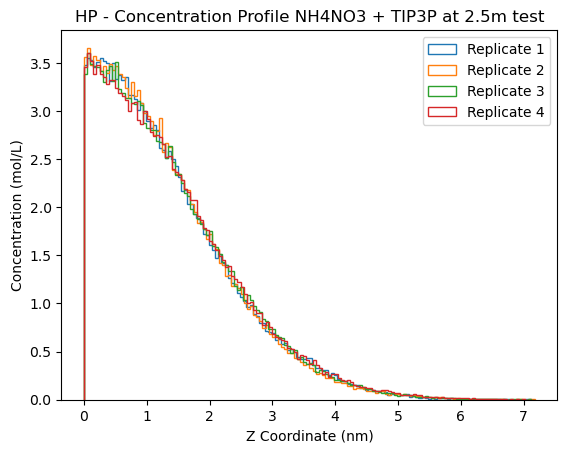

zvals[0] shape: (296000,)
zvals[1] shape: (296000,)
zvals[2] shape: (296000,)
zvals[3] shape: (296000,)


In [ ]:
zvals = []
concentration_profiles = []
z = []

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'
    N_i = salt_dict[f'{ion1}{ion2}'][f'Molality {mi1} mol/kg']['Number of Particles']
    frdir = f'{rdir}_{mi}m'

    for i in range(N_replicates):
        zvals_i = get_ion_array(us[mi][i], ions[mi][i])
        zvals.append(zvals_i)

        concs, bins, _ = plt.hist(
            zvals_i,
            bins=int(L_z * 10),
            weights=np.full_like(zvals_i, N_i / zvals_i.size),
            histtype='step',
            label=f"Replicate {i+1}"
        )
        concentration_profiles.append(concs)
        z.append(0.5 * (bins[1:] + bins[:-1]))

        plt.title(f'HP - Concentration Profile {ion1}{ion2} + {water} at {mi1}m {method_name}')
        plt.xlabel('Z Coordinate (nm)')
        plt.ylabel('Concentration (mol/L)')

    plt.legend()
    plt.savefig(f'{frdir}/conc_prof.png')
    plt.show()

# Convert to NumPy arrays
concentration_profiles = np.array(concentration_profiles)
z = np.array(z)

# Average z coordinates
z_mean = np.mean(z, axis=0)

for i, arr in enumerate(zvals):
    print(f'zvals[{i}] shape:', np.shape(arr))

# Flatten all ion positions for MLE analysis
zvals_all = np.array(zvals).flatten()

## Verify data

Verify that we have properly normalized the concentrations by intgrating over the box and ensuring we have the correct number of ions.

In [ ]:
print(f'Number of ions used: {N_i}')

for c in concentration_profiles:
    N_s = L_x * L_y * simpson(y=c, x=z_mean)
    c /= (N_s/N_i)
    
# verify normalization worked.
N_s_list=[]
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(y=c, x=z_mean)
    print('%.1f'% N_s)
    N_s_list.append(N_s)

N_s=math.ceil(np.mean(N_s_list))

# if int(N_s) == int(N_i):
#     print('Yep, checks out!')
# else:
#     raise ValueError('Somthing looks wrong... calculated number of ions does not match the number used. Check defined constants.')

Number of ions used: 148
148.0
148.0
148.0
148.0


In [ ]:
#Use the direct average of the four histograms for fitting. 
c_0 = np.mean(concentration_profiles,axis=0)

# Removing 0 values in the concentration from the concentration profile, and the corresponding z values,
# as we will be taking logarithms.
z_fit = z_mean[c_0 != 0]
c_fit = c_0[c_0 != 0]

## Unweighted least squares fitting

In [ ]:
initial_guess = [4,0.2,0]
# Right side/ y of equation 12
def y_values(z_fit):
    return -(0.5 * k.value_in_unit(kilojoule_per_mole/nanometer**2) * z_fit ** 2) * 1000 / (R * T) 

In [ ]:
# Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, initial_guess, args=(c_fit, y_values(z_fit)))

Plot the results of the unweighted fit 

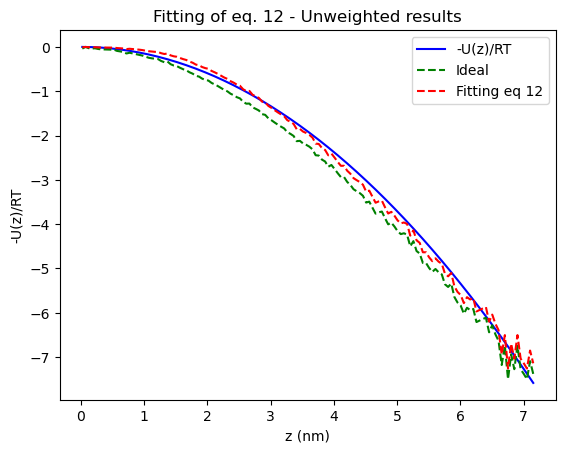

In [ ]:
plt.plot(z_fit, y_values(z_fit), 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Unweighted results')
plt.legend()
plt.show()

## Weighted least squares fitting

In [ ]:
## Finding weights 
norm = N_s/(L_x*L_y)
print(norm)

def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(np.subtract(calc_y(theta, x),y), 2)

6.423611111111112


In [ ]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values(z_fit)))

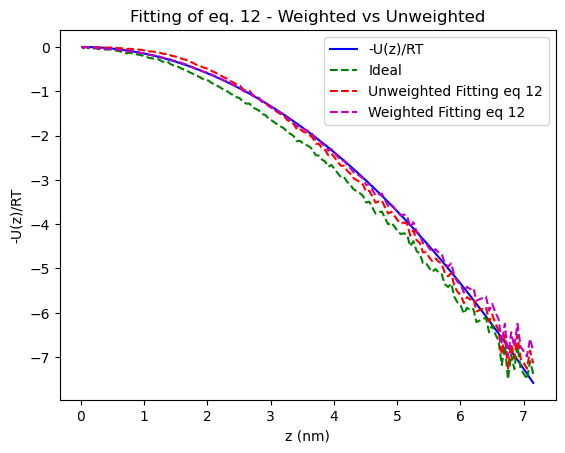

In [ ]:
# plot the results
plt.plot(z_fit, y_values(z_fit), 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Weighted vs Unweighted')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences.

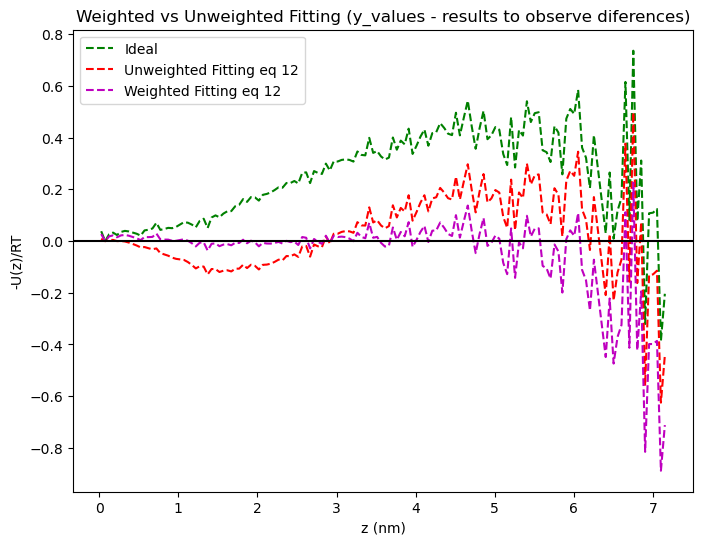

In [ ]:
# plot the results. Notice the plots are now being subtracted from the y_values results
plt.figure(figsize = (8,6))
plt.plot(z_fit, y_values(z_fit)-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values(z_fit)-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values(z_fit)-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.axhline(y=0, color= 'k')
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Weighted vs Unweighted Fitting (y_values - results to observe diferences)')
plt.legend()
plt.show()

In [ ]:
raise SystemExit("Stop here")

SystemExit: Stop here

In [ ]:
zlim = 4 #coordinate limit for where fitting is closer

#Stdev of unweighted results
yv = y_values(z_fit)
stdev_uw = np.std(yv[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of unweighted results: {stdev_uw}')

#Stdev of weighted results
stdev_w = np.std(yv[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of weighted results: {stdev_w}')

Stdev of unweighted results: 0.07176570826489913
Stdev of weighted results: 0.01902029714205856


Let's look at the distribution of the parameters with both types of fit.

## Bootstrapping parameters and osmotic coefficients (without and with weights)

In [ ]:
trialp = [4, 0.1,0.0]
# Function to perform bootstrapping over 4 profiles.
def bootstrap_profiles(profiles, n_samples, res_func):
    b_params = []
    b_profiles = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z_mean[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        result = least_squares(res_func, trialp, args=(c_fit, y_values(z_fit)))
        b_params.append(result.x)
        b_profiles.append(mean_profile)
    return np.array(b_profiles), np.array(b_params) # concentrations, and list of parameters

Param 0 = 21640.672846584737 +/- 24546.50140958008


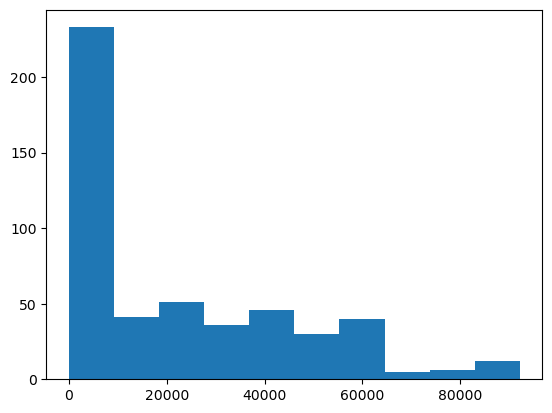

Param 1 = 0.08935295683903621 +/- 0.09712599999677707


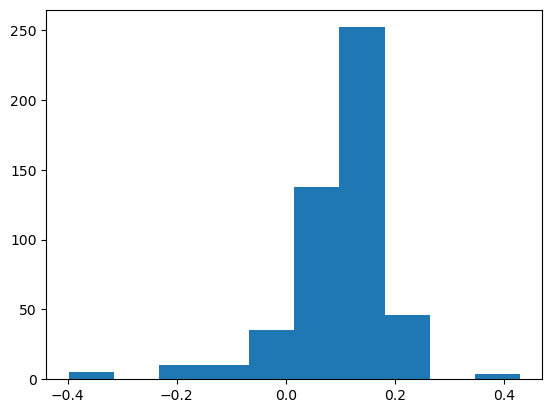

Param 2 = -0.05193576242971042 +/- 0.023805185344605875


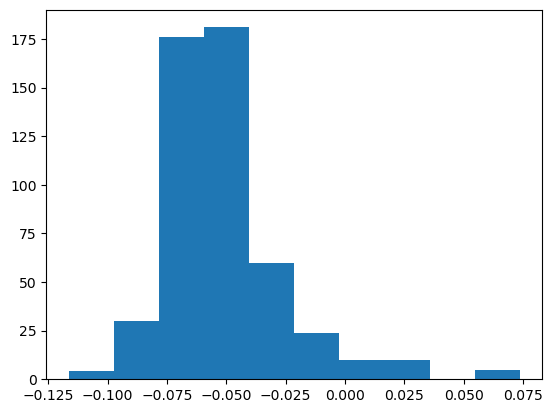

In [ ]:
# Perform bootstrapping with unweighted fit
bootstrap_profiles_unweighted, bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=residuals)
uw_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    uw_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

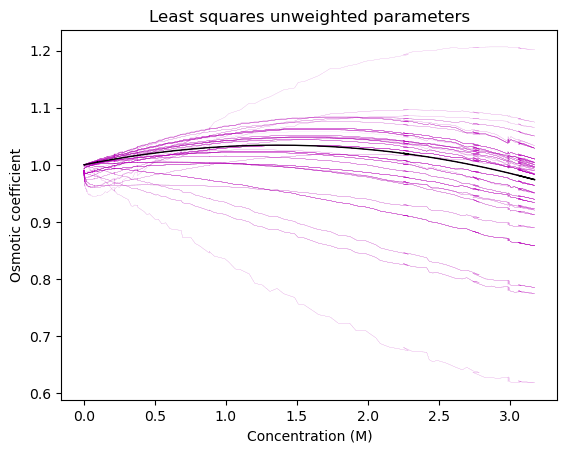

In [ ]:
# Plots of the osmotic coefficients with the unweighted parameters
ops = list()
ocs = list()
for p,c in zip(bootstrap_params_unweighted, bootstrap_profiles_unweighted):
    op,oc = osmotic_pressure(c,p)
    plt.plot(c_0,oc,lw=0.1,alpha=0.2,c='m')
    ops.append(op)
    ocs.append(oc)
opt_op = osmotic_pressure(c_0,result_unweighted.x)[0]
opt_oc = osmotic_pressure(c_0,result_unweighted.x)[1]
plt.plot(c_0,opt_oc,'k',lw=1,alpha=1)
# plt.ylim([0.9,1.5])
ops = np.array(ops)
ocs = np.array(ocs)
plt.title('Least squares unweighted parameters')
plt.xlabel('Concentration (M)')
plt.ylabel('Osmotic coefficient')
plt.show()

Param 0 = 133.86337150552228 +/- 259.81921684382826


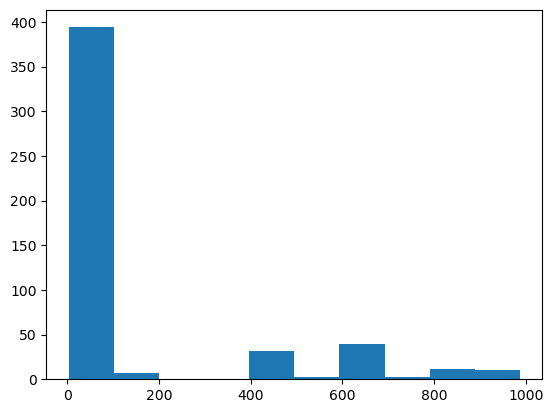

Param 1 = -0.13897097890092705 +/- 0.0456218848932543


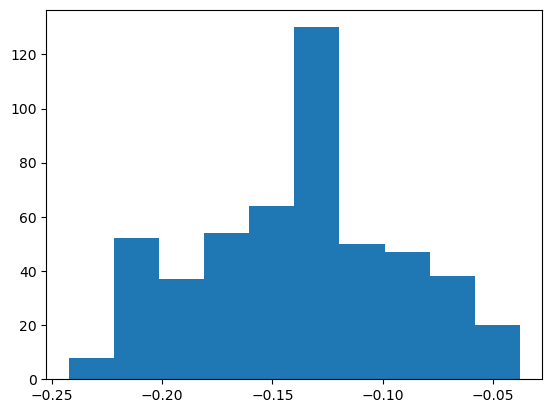

Param 2 = 0.008208885409913833 +/- 0.009072583132285502


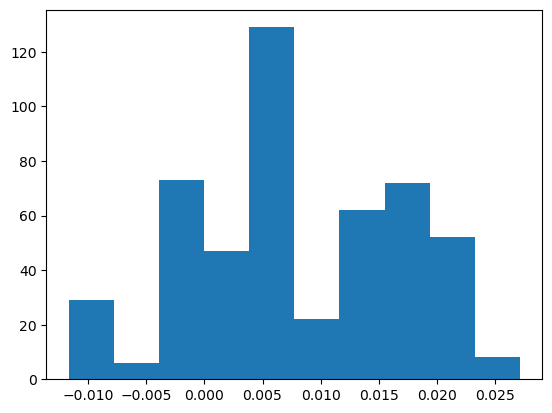

In [ ]:
# Perform bootstrapping with weighted residuals
bootstrap_profiles_weighted, bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=weighted_residuals)
w_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    w_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

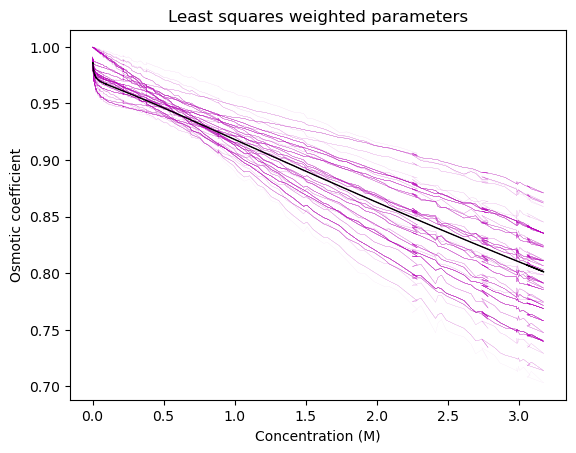

In [ ]:
# Plots of the osmotic coefficients with the weighted parameters
ops = list()
ocs = list()
for p,c in zip(bootstrap_params_weighted, bootstrap_profiles_weighted):
    op,oc = osmotic_pressure(c,p)
    plt.plot(c_0,oc,lw=0.1,alpha=0.2,c='m')
    ops.append(op)
    ocs.append(oc)
opt_op = osmotic_pressure(c_0,result_weighted.x)[0]
opt_oc = osmotic_pressure(c_0,result_weighted.x)[1]
# plt.ylim([0.8,1.6])
plt.plot(c_0,opt_oc,'k',lw=1,alpha=1)
ops = np.array(ops)
ocs = np.array(ocs)
plt.title('Least squares weighted parameters')
plt.xlabel('Concentration (M)')
plt.ylabel('Osmotic coefficient')
plt.show()

# Maximum Likelihood Parameter Optimization

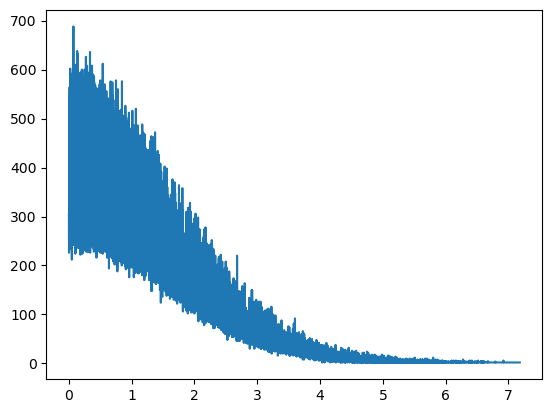

In [ ]:
zsparse_o,zcount_o = np.unique(zvals_all,return_counts=True)
plt.plot(zsparse_o,zcount_o)
plt.show()

## Normalization

Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [ ]:
red_U_app = lambda z: 1000*k.value_in_unit(kilojoule_per_mole/nanometer**2)*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

In [ ]:
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k.value_in_unit(kilojoule_per_mole/nanometer**2))) #analytical solution
print('%.3f'%ideal_norm)

2.301


In [ ]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm)
print('%.3f'%cmax_ideal)

2.792


## Calculation functions

In [ ]:
def logprobfunc(a,z,cz,A=A):
    '''
    Function that calculates maximum concentration.
    '''
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [ ]:
def czfunc(a,z,cz):
    '''
    Function that iterates the calculation of a concentration until it self consistently matches.
    '''
    cznew = np.exp(logprobfunc(a,z,cz))  # exponential of eq 12 for ln c/cmax for the data points
    zunique, locs = np.unique(z,return_index=True)  # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],x = zunique) # integrate
    cznorm_ratio = ideal_norm/newarea # get normalization ratio
    return (cmax_ideal*cznorm_ratio)*cznew

In [ ]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):
    '''
    Function that calculates the concentration from given parameters, z coordinate list, starting concentration list.
    '''

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

In [ ]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    '''
    Function that calcualtes the logarithm term, arranged as a solution to equation 12, using 
    new generated concentrations from given parameters
    '''
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [ ]:
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    '''
    Function to perform bootstrapping over samples
    '''
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

## Fitting

In [ ]:
newp = np.array([1.35,0.33,-0.04]) # propose initial parameter guesses

In [ ]:
zsparse_all, zcount_all = np.unique(zvals_all,return_counts=True) # get sparse data of z coordinate list

In [ ]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True) # get concentrations for sparse z coordinate list

0 10.38949
1 1.6154091
2 0.30280703
3 0.058796242
4 0.011727182
5 0.0023692385
6 0.00048099647


In [ ]:
results = minimize(neglliter,newp,args=(zsparse_all,c_new_sparse_all,zcount_all),method = 'Nelder-Mead') # minimize using sparse data
full_opt=results.x
print(full_opt)

[ 2.84548087e+01 -2.14783864e-01  2.80747543e-02]


In [ ]:
c_opt_sparse_all = converge_c(full_opt,zsparse_all,cz_start=c_new_sparse_all,verbose=False) # get conventrations from minimized/optimized parameters

## Bootstrapping

In [ ]:
bparams,bcs = bootstrap_samples(zvals_all, 250, neglliter, results.x) # Change number of bootstraps desired, using 500 here for better statistics.

0 [ 9.23442013e+05 -2.13085275e-01  2.73051488e-02] 507909.8345313144
1 [ 1.08058518e+06 -2.24056776e-01  3.04278217e-02] 507032.2745553605
2 [ 1.43554567e+06 -2.26565810e-01  3.17868705e-02] 509009.5951915291
3 [ 2.49774724e+06 -2.20964081e-01  2.98008848e-02] 507822.78389829746
4 [ 8.51382263e+05 -2.18283505e-01  2.88661168e-02] 507540.75333344744
5 [ 8.58837604e+05 -2.17476323e-01  2.83239783e-02] 507034.08491036703
6 [ 1.49010449e+06 -2.18393634e-01  2.96476438e-02] 509438.06499482674
7 [ 1.19455250e+06 -2.23676542e-01  3.05676343e-02] 508095.2440562727
8 [ 1.27819898e+06 -2.15583742e-01  2.87472760e-02] 509856.8088751323
9 [ 1.20327471e+06 -2.22950749e-01  2.99948647e-02] 506858.4200822255
10 [ 1.03486840e+06 -2.14626307e-01  2.74949393e-02] 507341.2481990776
11 [ 6.92525799e+05 -2.20764220e-01  2.98236548e-02] 508024.8810952766
12 [ 1.92078706e+06 -2.17784885e-01  2.87519832e-02] 508027.7022986466
13 [ 1.44748526e+06 -2.15820636e-01  2.82952378e-02] 508588.1831563667
14 [ 1.27828

### Results Statistics

In [ ]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.          0.01074892 -0.02303897]
 [ 0.01074892  1.         -0.97893018]
 [-0.02303897 -0.97893018  1.        ]]


Parameter 0 = 1192495.7707077307 +/- 462691.894358549


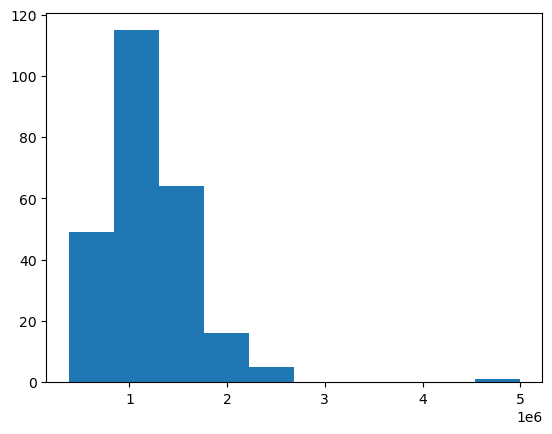

Parameter 1 = -0.220240762929269 +/- 0.004680050043559933


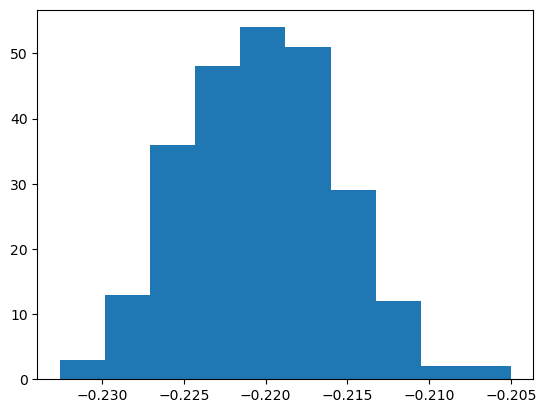

Parameter 2 = 0.02958766955955202 +/- 0.0012526255628157639


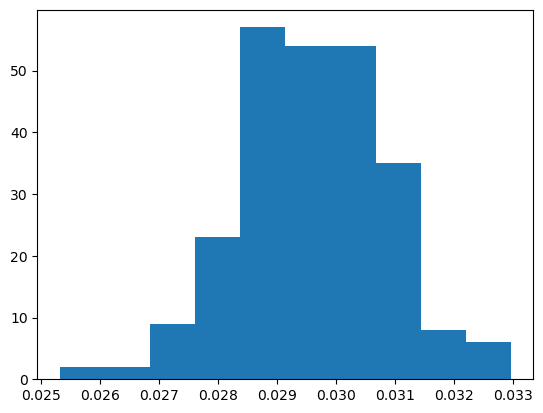

In [ ]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd)
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parameter {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

In [ ]:
def scatplots(bparams,bcs,c_opt_sparse_all,full_opt,author):
    # scatter plots of the osmotic coefficients and osmotic pressures
    ops = list()
    ocs = list()
    for p,c in zip(bparams,bcs):
        op,oc = osmotic_pressure(c,p)
        plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
        ops.append(op)
        ocs.append(oc)
    opt_oc = osmotic_pressure(c_opt_sparse_all,full_opt)[1]
    opt_op = osmotic_pressure(c_opt_sparse_all,full_opt)[0]
    plt.plot(c_opt_sparse_all,opt_oc,'k',lw=1,alpha=1)
    # plt.ylim([0.9,1.25])
    ops = np.array(ops)
    ocs = np.array(ocs)
    plt.title(f'Maximum Likelihood Approximation - {author}')
    plt.xlabel('Concentration (M)')
    plt.ylabel('Osmotic coefficient')
    plt.show()
    return ocs,ops,opt_oc,opt_op

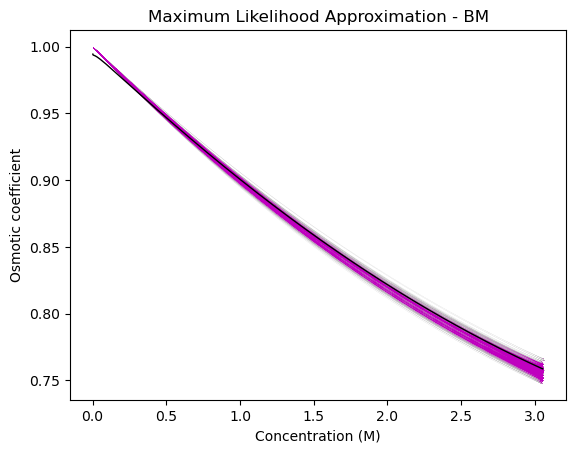

In [ ]:
ocs,ops,opt_oc,opt_op=scatplots(bparams,bcs,c_opt_sparse_all,full_opt,'BM')

## Results

## Getting and saving results

In [ ]:
def calculate_osmotic_properties(target_values,percentiles_oc,percentiles_op,c_opt_sparse_all,opt_oc,opt_op):
    """
    Calculates osmotic coefficient and osmotic pressure properties for a list of target values.

    Parameters:
        target_values (list): List of concentration values to analyze.

    Returns:
        dict: Dictionary containing osmotic coefficient, osmotic pressure, and their respective errors.
    """

    results = {
        'osmotic_coefficient': [],
        'osmotic_coefficient_error': [],
        'osmotic_pressure': [],
        'osmotic_pressure_error': []
    }

    for target_value in target_values:
        closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
        
        # Osmotic coefficient calculations
        y_oc = opt_oc[closest_index]
        uncertainty_oc = (percentiles_oc["1s"][1][closest_index] - percentiles_oc["1s"][0][closest_index]) / 2
        results['osmotic_coefficient'].append(float(y_oc))
        results['osmotic_coefficient_error'].append(float(uncertainty_oc))

        # Osmotic pressure calculations
        y_op = opt_op[closest_index]
        uncertainty_op = (percentiles_op["1s"][1][closest_index] - percentiles_op["1s"][0][closest_index]) / 2
        results['osmotic_pressure'].append(float(y_op))
        results['osmotic_pressure_error'].append(float(uncertainty_op))
        
        print(f"Closest to {target_value:.2f}: {closest_value:.2f} at index {closest_index}, "
              f"OC: {y_oc:.3f} ± {uncertainty_oc:.3f},"
              f"OP: {y_op:.3f} ± {uncertainty_op:.3f}")

    return results


In [ ]:
bounds = {
    "95": {"lower": 2.5, "upper": 97.5},
    "1s": {"lower": 16, "upper": 84}
}

# Compute percentile bounds
percentiles_oc = {
    key: np.percentile(ocs, [bounds[key]["lower"], bounds[key]["upper"]], axis=0)
    for key in bounds
}
percentiles_op = {
    key: np.percentile(ops, [bounds[key]["lower"], bounds[key]["upper"]], axis=0)
    for key in bounds
}

In [ ]:
osmotic_results=calculate_osmotic_properties(exp_concs,percentiles_oc,percentiles_op,c_opt_sparse_all,opt_oc,opt_op)

Closest to 0.10: 0.10 at index 8428, OC: 0.986 ± 0.000,OP: 4.883 ± 0.018
Closest to 0.20: 0.20 at index 7443, OC: 0.977 ± 0.000,OP: 9.622 ± 0.034
Closest to 0.29: 0.29 at index 6820, OC: 0.967 ± 0.001,OP: 14.223 ± 0.048
Closest to 0.39: 0.39 at index 6351, OC: 0.957 ± 0.001,OP: 18.699 ± 0.060
Closest to 0.49: 0.49 at index 5973, OC: 0.948 ± 0.001,OP: 23.015 ± 0.071
Closest to 0.58: 0.58 at index 5650, OC: 0.939 ± 0.001,OP: 27.226 ± 0.081
Closest to 0.68: 0.68 at index 5370, OC: 0.930 ± 0.001,OP: 31.340 ± 0.089
Closest to 0.77: 0.77 at index 5121, OC: 0.921 ± 0.001,OP: 35.318 ± 0.097
Closest to 0.86: 0.86 at index 4893, OC: 0.913 ± 0.002,OP: 39.170 ± 0.104
Closest to 0.95: 0.95 at index 4684, OC: 0.905 ± 0.002,OP: 42.945 ± 0.111
Closest to 1.13: 1.13 at index 4309, OC: 0.889 ± 0.002,OP: 50.141 ± 0.126
Closest to 1.31: 1.31 at index 3975, OC: 0.874 ± 0.002,OP: 56.995 ± 0.142
Closest to 1.48: 1.48 at index 3670, OC: 0.860 ± 0.003,OP: 63.513 ± 0.158
Closest to 1.65: 1.65 at index 3378, OC:

Save results

In [ ]:
# Process and write to JSON
json_results = json.dumps(format_dict(osmotic_results), indent=4)

for mol in molalities:
    if mol % 1 == 0:
        mi1 = f"{mol:.1f}"       # '1.0'
        mi = str(int(mol))       # '1'
    else:
        mi = f"{mol:.1f}".replace('.', '')  # '0.5' → '05'
        mi1 = f"{mol:.1f}"       # '0.5'
    frdir = f'{rdir}_{mi}m'

    with open(f"{frdir}/{ion1}{ion2}_final_results_{mi}m.json", "w") as outfile:
        outfile.write(json_results)

    # Write results to CSV
    csv_filename = f"{frdir}/{ion1}{ion2}_final_results_{mi}m.csv"
    with open(csv_filename, mode='w', newline='') as csvfile:
        fieldnames = ["Molality", "Osmotic Coefficient", "Osmotic Coefficient Error", "Osmotic Pressure", "Osmotic Pressure Error"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for i, molality in enumerate(salt_dict[f"{ion1}{ion2}"].keys()):
            writer.writerow({
                "Molality": molality.split()[1],  # Extract molality value
                "Osmotic Coefficient": osmotic_results['osmotic_coefficient'][i],
                "Osmotic Coefficient Error": osmotic_results["osmotic_coefficient_error"][i],
                "Osmotic Pressure": osmotic_results["osmotic_pressure"][i],
                "Osmotic Pressure Error": osmotic_results["osmotic_pressure_error"][i]
            })

    print(f"Results saved to {csv_filename}")

Results saved to HP_NH4NO3_TIP3P_test/result_files_25m/NH4NO3_final_results_25m.csv


## Plotting Results

In [ ]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

Osmotic Coefficient vs Concentration Plot

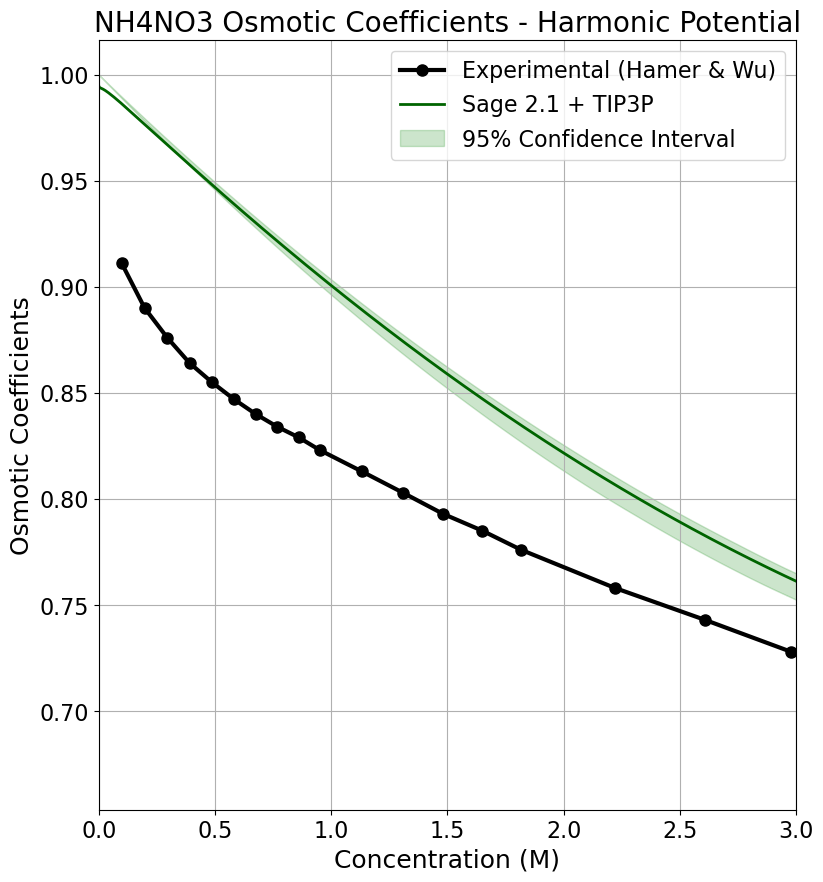

In [ ]:
# Extract percentile-based confidence intervals
lower_bound_95_oc, upper_bound_95_oc = percentiles_oc["95"]
lower_bound_1s_oc, upper_bound_1s_oc = percentiles_oc["1s"]

# Plot osmotic coefficients vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Harmonic Potential data of osmotic coefficients with 95% confidence interval
plt.plot(c_opt_sparse_all, opt_oc, lw=2, label=f'{ff_used}', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')

plt.xlim(0,molalities[-1]+0.5)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Coefficients', fontsize=MEDIUM_SIZE)
plt.legend()
plt.grid()
plt.title(f'{ion1}{ion2} Osmotic Coefficients - Harmonic Potential', fontsize=BIGGER_SIZE)
plt.savefig(f'{frdir}/{ion1}{ion2}_oc.png')
plt.show()

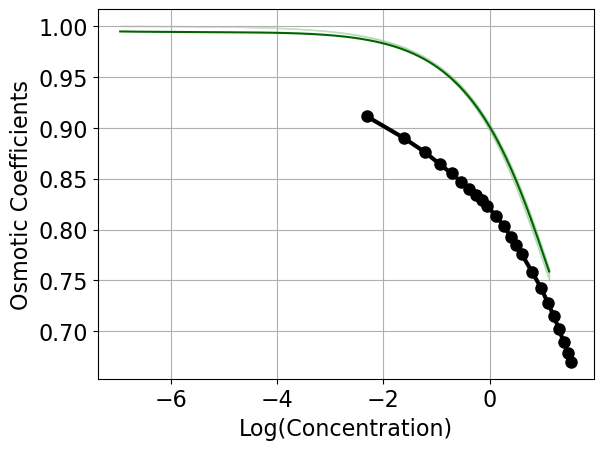

In [ ]:
# osmotic coefficients vs ln of concentration
plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile', color='darkgreen')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')

# ln of experimental data
plt.plot(np.log(exp_concs), yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.grid()
plt.show()

Osmotic Pressure vs Concentration Plot

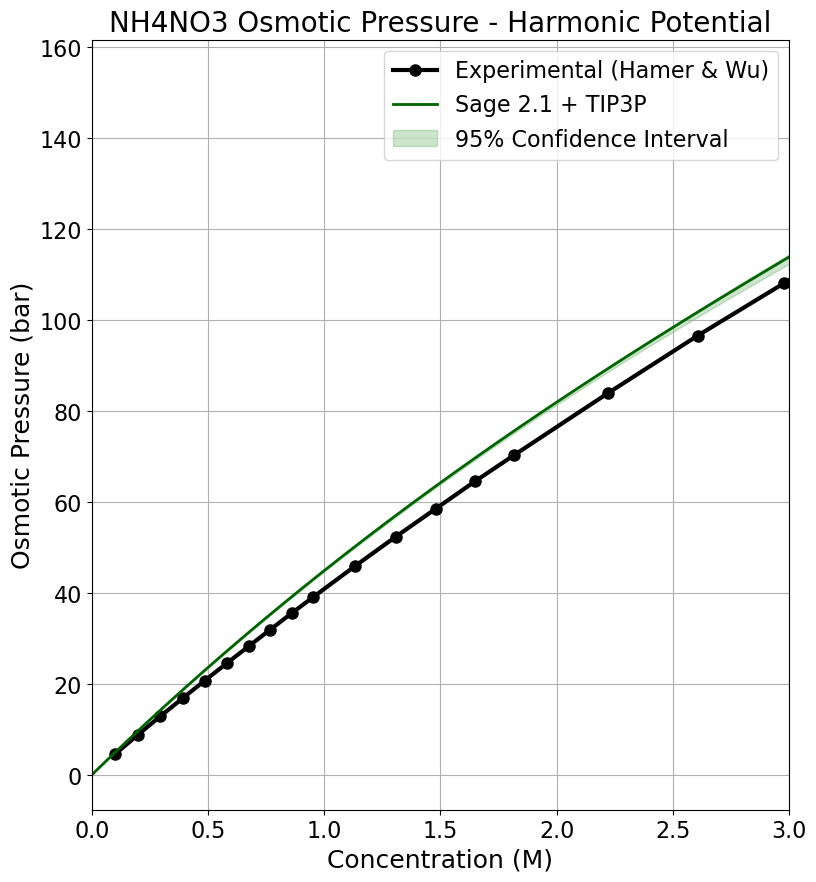

In [ ]:
lower_bound_95_op, upper_bound_95_op = percentiles_op["95"]
lower_bound_1s_op, upper_bound_1s_op = percentiles_op["1s"]

# Plot osmotic pressure vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Harmonic Potential data of osmotic pressure with 95% confidence interval
plt.plot(c_opt_sparse_all, opt_op, lw=2, label=f'{ff_used}', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound_95_op, upper_bound_95_op, color='g', alpha=0.2, label='95% Confidence Interval')

# # Add labels to the specific experimental points
# special_labels = {0.98: '1m', 1.92: '2m', 2.82: '3m'}
# for i in range(len(exp_concs_values)):
#     x_val = exp_concs_values[i]  # Scalar value
#     y_val = yexpOP[i]
#     if x_val in special_labels:  # Check if x_val is in the special_labels dictionary
#         plt.text(x_val, y_val, f"({special_labels[x_val]})", fontsize=12, ha='right')

plt.xlim(0,molalities[-1]+0.5)
plt.title(f'{ion1}{ion2} Osmotic Pressure - Harmonic Potential', fontsize=BIGGER_SIZE)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Pressure (bar)', fontsize=MEDIUM_SIZE)
plt.legend()
plt.grid()
plt.savefig(f'{frdir}/{ion1}{ion2}_op.png')
plt.show()